In [1]:
import os
import numpy as np
from scripts.mrs_ue_utils import generate_dem
from skimage.restoration import unwrap_phase
import matplotlib.pyplot as plt
import scienceplots
from typing import List, Tuple, Any

# Exercise 6: **Phase Unwrapping**

First, load and visualise them. Next, try to write your own unwrapping algorithm and unwrap the 1-D phase array for line number 400 and the whole column in all images.

Hint: You have to implement a cumulative summation/subtraction, where the sign changes according to phase $x_i - x_{i-1}$ > pi larger than $\pi$

For the 2-D images, unwrap the phases with the following function

`unwrapped_phases = skimage.restoration.unwrap_phase(np_ar)`


## 6.1 Which interferogram(s) relate(s) to the given input DEM?


## 6.2 Do all results look valid? If not, what could be the reason?


## 6.3 What problems can occur during phase unwrapping?


## 6.4 To what input parameter do the fringes in the interferogram relate to, i.e. what parameter(s) need(s) to be considered to compute the relative heights?


In [2]:
interfero1 = np.load(os.path.join('data', 'interferogram_1.npy'))
interfero2 = np.load(os.path.join('data', 'interferogram_2.npy'))
interfero3 = np.load(os.path.join('data', 'interferogram_3.npy'))

print(
    f'Interferogram 1: vals in interval [{interfero1.min(), interfero1.max()}], shape {interfero1.shape}'
)
print(
    f'Interferogram 2: vals in interval [{interfero2.min(), interfero2.max()}], shape {interfero2.shape}'
)
print(
    f'Interferogram 3: vals in interval [{interfero3.min(), interfero3.max()}], shape {interfero3.shape}'
)

Interferogram 1: vals in interval [(0.0, 6.2831821044197795)], shape (1000, 1000)
Interferogram 2: vals in interval [(0.0, 6.283177408105651)], shape (1000, 1000)
Interferogram 3: vals in interval [(0.0, 6.283180285892406)], shape (1000, 1000)


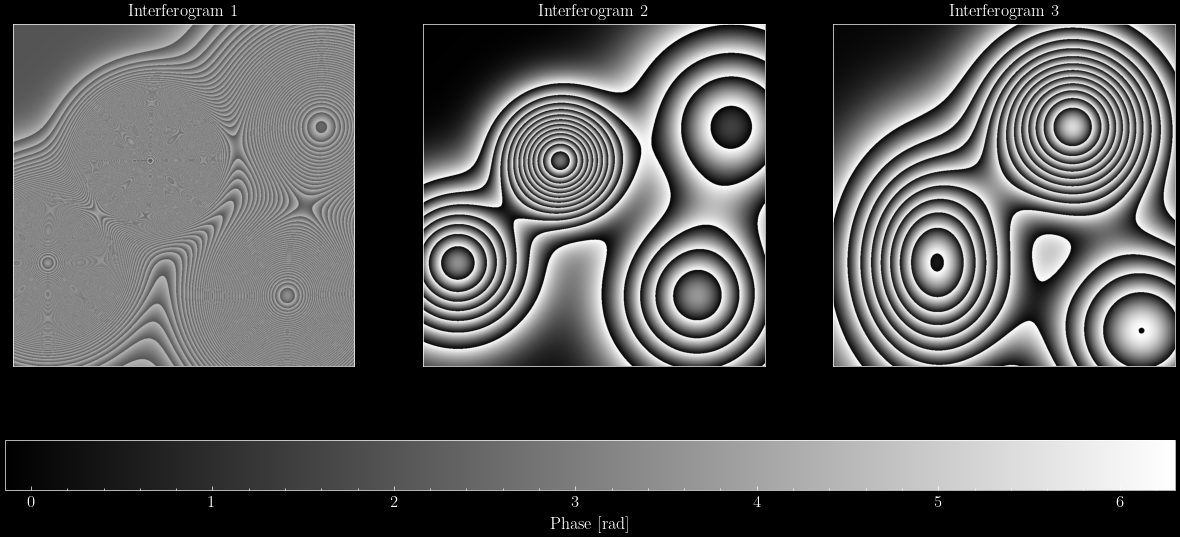

In [17]:
fig = plt.figure(figsize=(15, 10))
plt.style.use('science')
ax0 = fig.add_subplot(131)
ax0.imshow(interfero1, cmap='gray')
ax0.set_title('Interferogram 1')
ax0.set_xticks([])
ax0.set_yticks([])

ax1 = fig.add_subplot(132)
ax1.imshow(interfero2, cmap='gray')
ax1.set_title('Interferogram 2')
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(133)
ax2.imshow(interfero3, cmap='gray')
ax2.set_title('Interferogram 3')
ax2.set_xticks([])
ax2.set_yticks([])

# Create a single horizontal colorbar
cbar_ax = fig.add_axes([0.12, 0.2, 0.78,
                        0.05])  # Adjust the position and size of the colorbar
cbar = fig.colorbar(ax2.imshow(interfero3, cmap='gray'),
                    cax=cbar_ax,
                    orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Phase [rad]', fontsize=12)


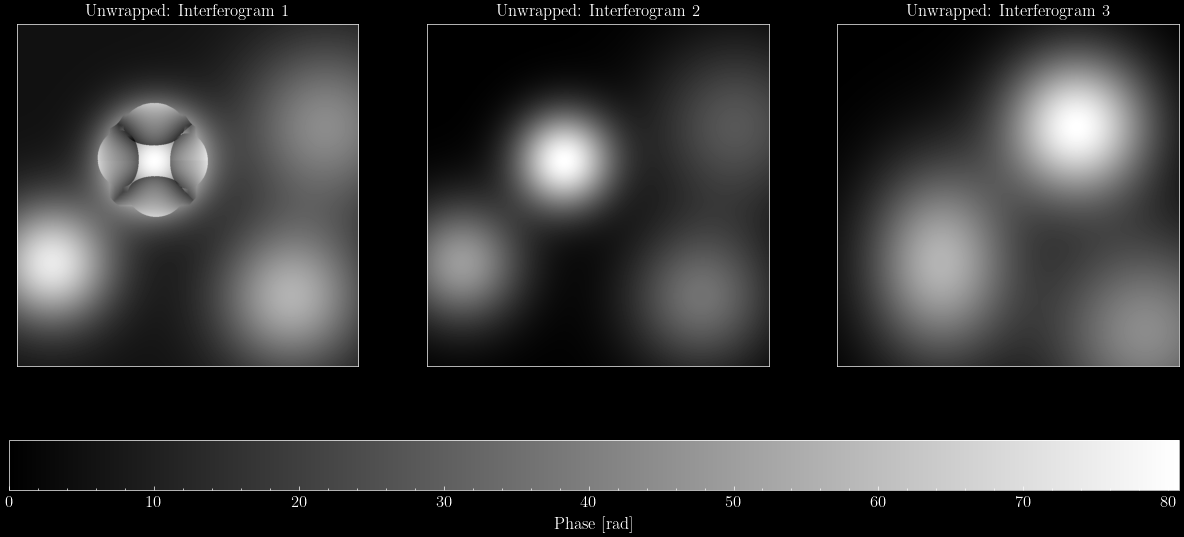

In [21]:
fig = plt.figure(figsize=(15, 10))
plt.style.use('science')
ax0 = fig.add_subplot(131)
ax0.imshow(unwrap_phase(interfero1), cmap='gray')
ax0.set_title('Unwrapped: Interferogram 1')
ax0.set_xticks([])
ax0.set_yticks([])

ax1 = fig.add_subplot(132)
ax1.imshow(unwrap_phase(interfero2), cmap='gray')
ax1.set_title('Unwrapped: Interferogram 2')
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(133)
ax2.imshow(unwrap_phase(interfero3), cmap='gray')
ax2.set_title('Unwrapped: Interferogram 3')
ax2.set_xticks([])
ax2.set_yticks([])

# Create a single horizontal colorbar
cbar_ax = fig.add_axes([0.12, 0.2, 0.78,
                        0.05])  # Adjust the position and size of the colorbar
cbar = fig.colorbar(ax2.imshow(unwrap_phase(interfero3), cmap='gray'),
                    cax=cbar_ax,
                    orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Phase [rad]', fontsize=12)


In [4]:
def plot_slice(line: Tuple[int, int] = (None, None),
               col: Tuple[int, int] = (
                   None, None)) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    if line[0] is None:
        line_s = 0
    else:
        line_s = line[0]

    if line[1] is None:
        line_e = interfero1.shape[0]
    else:
        line_e = line[1]

    if col[0] is None:
        col_s = 0
    else:
        col_s = col[0]

    if col[1] is None:
        col_e = interfero1.shape[1]
    else:
        col_e = col[1]

    line1 = interfero1[line_s:line_e, col_s:col_e]
    line2 = interfero2[line_s:line_e, col_s:col_e]
    line3 = interfero3[line_s:line_e, col_s:col_e]

    fig = plt.figure(2)
    plt.style.use('science')
    fig.suptitle(f'Lines ({line_s} : {line_e}) and column ({col_s} : {col_e})',
                 fontsize=16)

    ax0 = fig.add_subplot(311)
    ax0.plot(line1)

    ax1 = fig.add_subplot(312)
    ax1.plot(line2)

    ax2 = fig.add_subplot(313)
    ax2.plot(line3)

    return line1[0], line2[0], line3[0]

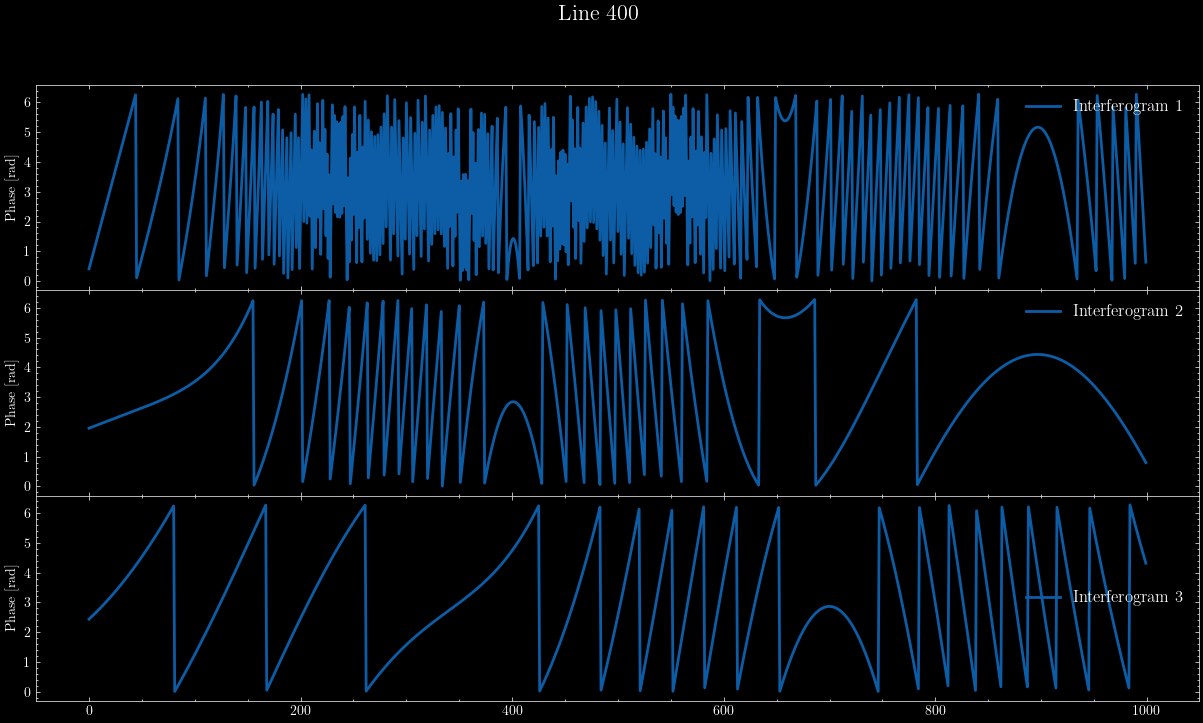

In [5]:
line1 = interfero1[399, :]
line2 = interfero2[399, :]
line3 = interfero3[399, :]

fig = plt.figure(2, figsize=(15, 8))
plt.style.use('science')

ax0 = fig.add_subplot(311)
ax0.plot(line1, linewidth=2, label='Interferogram 1')
ax0.tick_params(axis='x', labelbottom=False)
ax0.set_ylabel('Phase [rad]')
ax0.legend(fontsize=12)

ax1 = fig.add_subplot(312, sharex=ax0)
ax1.plot(line2, linewidth=2, label='Interferogram 2')
ax1.tick_params(axis='x', labelbottom=False)
ax1.set_ylabel('Phase [rad]')
ax1.legend(fontsize=12)

ax2 = fig.add_subplot(313, sharex=ax0)
ax2.plot(line3, linewidth=2, label='Interferogram 3')
ax2.set_ylabel('Phase [rad]')
ax2.legend(fontsize=12)

fig.suptitle('Line 400', fontsize=16)

plt.subplots_adjust(hspace=0)


In [6]:
def compare_adjacent_elements(line):
    diff = np.diff(line)
    return np.where(np.abs(diff) > np.pi)[0]


In [7]:
def find_diff_greater_than_pi(
        line: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    diff = np.diff(line)
    # indices = np.where((np.abs(diff) > np.pi)
    #                    | (np.abs(diff) < -1 * np.pi))[0] + 1
    indices = np.where(diff > np.pi)[0] + 1
    values = line[indices]
    return indices, values


def find_diff_smaller_than_minus_pi(
        line: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    diff = np.diff(line)
    # indices = np.where((np.abs(diff) > np.pi)
    #                    | (np.abs(diff) < -1 * np.pi))[0] + 1
    indices = np.where(diff < -1 * np.pi)[0] + 1
    values = line[indices]
    return indices, values


def slice_line(line: np.ndarray, func: Any) -> np.ndarray[np.ndarray]:
    indices, values = func(line)
    slices = [
        line[i:j] for i, j in zip([0] + indices.tolist(),
                                  indices.tolist() + [len(line)])
    ]
    return slices


def anneal_slices(line: np.ndarray, func: Any) -> np.ndarray:
    slices = slice_line(line, func)
    counts = 0
    for i, slice in enumerate(slices):
        counts += len(slice)
        if i == 0:
            continue
        if func.__name__ == 'find_diff_greater_than_pi':
            slices[i] -= slices[i - 1][-1]
        elif func.__name__ == 'find_diff_smaller_than_minus_pi':
            slices[i] += slices[i - 1][-1]
    return np.concatenate(slices)


# anneal_slices(line1)

line_1_annealed_1 = anneal_slices(line1, find_diff_greater_than_pi)
line_1_annealed = anneal_slices(line_1_annealed_1,
                                find_diff_smaller_than_minus_pi)

line_2_annealed_1 = anneal_slices(line2, find_diff_greater_than_pi)
line_2_annealed = anneal_slices(line_2_annealed_1,
                                find_diff_smaller_than_minus_pi)

line_3_annealed_1 = anneal_slices(line3, find_diff_greater_than_pi)
line_3_annealed = anneal_slices(line_3_annealed_1,
                                find_diff_smaller_than_minus_pi)

print(find_diff_smaller_than_minus_pi)


<function find_diff_smaller_than_minus_pi at 0x111fddf80>


In [8]:
# def find_elements_greater_than_pi(
#         line: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
#     diff = np.diff(line)
#     indices_up = np.where(diff > np.pi)[0] + 1
#     indices_down = np.where(diff < -1 * np.pi)[0] + 1
#     values_up = line[indices_up]
#     values_down = line[indices_down]
#     return (indices_up, values_up), (indices_down, values_down)

# def slice_line(line: np.ndarray, indices: np.ndarray,
#                values: np.ndarray) -> np.ndarray[np.ndarray]:
#     # indices, values = find_elements_greater_than_pi(line)
#     slices = [
#         line[i:j] for i, j in zip([0] + indices.tolist(),
#                                   indices.tolist() + [len(line)])
#     ]
#     return slices

# def anneal_slices(line: np.ndarray, indices: np.ndarray, values: np.ndarray,
#                   sign: bool) -> np.ndarray:
#     slices = slice_line(line, indices, values)
#     print(f'slices: {len(slices)} ')
#     counts = 0
#     for i, slice in enumerate(slices):
#         counts += len(slice)
#         if i == 0:
#             continue
#         if sign:
#             slices[i] += slices[i - 1][-1]
#         else:
#             slices[i] -= slices[i - 1][-1]
#     return np.concatenate(slices)

# (indices_up1,
#  values_up1), (indices_down1,
#                values_down1) = find_elements_greater_than_pi(line1)
# (indices_up2,
#  values_up2), (indices_down2,
#                values_down2) = find_elements_greater_than_pi(line2)
# (indices_up3,
#  values_up3), (indices_down3,
#                values_down3) = find_elements_greater_than_pi(line3)
# # len(
# #     anneal_slices(anneal_slices(line1, indices_up1, values_up1, sign=True),
# #                   indices_down1,
# #                   values_down1,
# #                   sign=False))


In [9]:
# def unwrap_1d(line: np.ndarray) -> np.ndarray:
#     counter_p, counter_m = 0, 0
#     for i, element in enumerate(line):
#         if i == 0:
#             continue

#         if line[i] - line[i - 1] < -1*np.pi:
#             print(line[i], line[i - 1], line[i] - line[i - 1])
#             seg_a, seg_b = line[:i], line[i:]
#             seg_b += seg_a[-1]
#             line = np.concatenate([seg_a, seg_b])
#             counter_p += 1

#         if line[i] - line[i - 1] > np.pi:
#             seg_a, seg_b = line[:i], line[i:]
#             seg_b -= seg_a[-1]
#             line = np.concatenate([seg_a, seg_b])
#             counter_m += 1

#     print(counter_p, counter_m)
#     return line

In [10]:
# plt.figure()
# plt.plot(line3)
# plt.plot(unwrap_1d(line3))

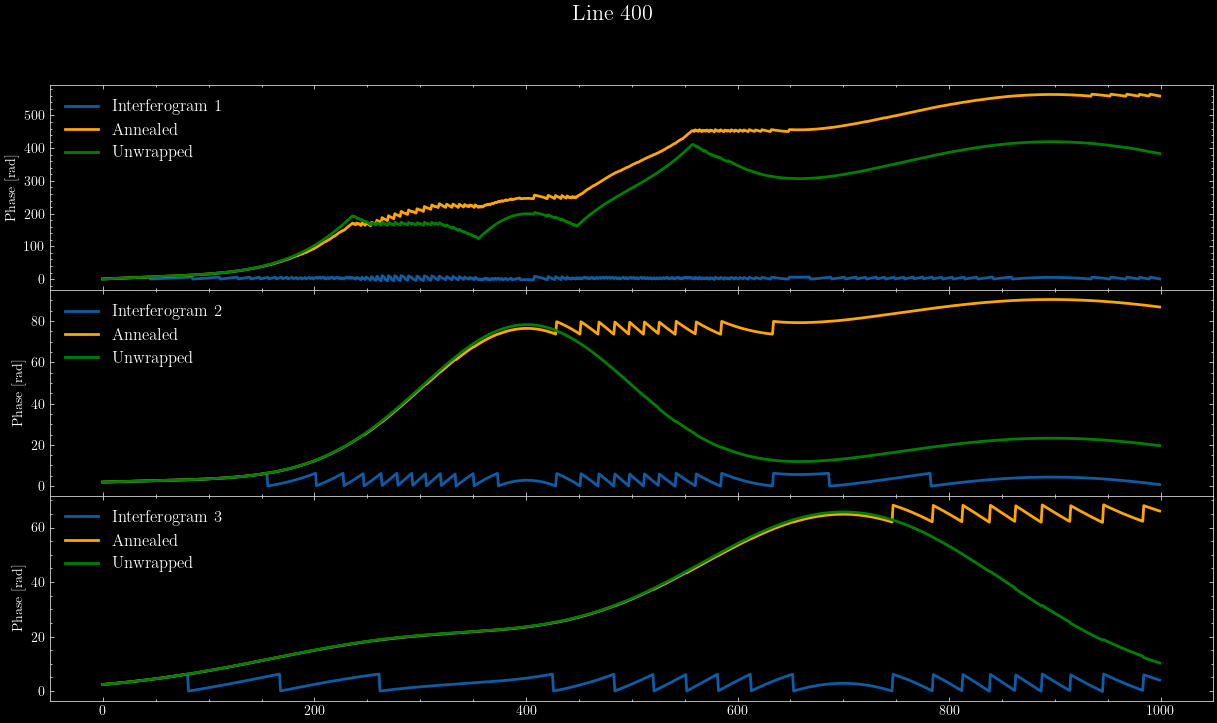

In [23]:
line1 = interfero1[399, :]
line2 = interfero2[399, :]
line3 = interfero3[399, :]

fig = plt.figure(2, figsize=(15, 8))
plt.style.use('science')

ax0 = fig.add_subplot(311)
ax0.plot(line1, linewidth=2, label='Interferogram 1')
ax0.plot(line_1_annealed, linewidth=2, color='orange', label='Annealed')
ax0.plot(unwrap_phase(interfero1[399, :]),
         linewidth=2,
         color='green',
         label='Unwrapped')
ax0.tick_params(axis='x', labelbottom=False)
ax0.set_ylabel('Phase [rad]')
ax0.legend(fontsize=12)

ax1 = fig.add_subplot(312, sharex=ax0)
ax1.plot(line2, linewidth=2, label='Interferogram 2')

ax1.plot(line_2_annealed, linewidth=2, color='orange', label='Annealed')
ax1.plot(unwrap_phase(interfero2[399, :]),
         linewidth=2,
         color='green',
         label='Unwrapped')
ax1.tick_params(axis='x', labelbottom=False)
ax1.set_ylabel('Phase [rad]')
ax1.legend(fontsize=12)

ax2 = fig.add_subplot(313, sharex=ax0)
ax2.plot(line3, linewidth=2, label='Interferogram 3')

ax2.plot(line_3_annealed, linewidth=2, color='orange', label='Annealed')
ax2.plot(unwrap_phase(interfero3[399, :]),
         linewidth=2,
         color='green',
         label='Unwrapped')
ax2.set_ylabel('Phase [rad]')
ax2.legend(fontsize=12)

fig.suptitle('Line 400', fontsize=16)

plt.subplots_adjust(hspace=0)


In [12]:
# line1 = interfero1[399, :]
# line2 = interfero2[399, :]
# line3 = interfero3[399, :]

# fig = plt.figure(2, figsize=(15, 8))
# plt.style.use('science')

# ax0 = fig.add_subplot(311)
# ax0.plot(line1, linewidth=2, label='Interferogram 1')
# ax0.scatter(*find_elements_greater_than_pi(line1),
#             marker='o',
#             color='red',
#             label=r'$x_i - x_{i-1}$ $>$ $\pi$')
# ax0.plot(anneal_slices(line1), linewidth=2, color='orange', label='Annealed')
# ax0.tick_params(axis='x', labelbottom=False)
# ax0.set_ylabel('Phase [rad]')
# ax0.legend(fontsize=12)

# ax1 = fig.add_subplot(312, sharex=ax0)
# ax1.plot(line2, linewidth=2, label='Interferogram 2')
# ax1.scatter(*find_elements_greater_than_pi(line2),
#             marker='o',
#             color='red',
#             label=r'$x_i - x_{i-1}$ $>$ $\pi$')
# ax1.plot(anneal_slices(line2), linewidth=2, color='orange', label='Annealed')
# ax1.tick_params(axis='x', labelbottom=False)
# ax1.set_ylabel('Phase [rad]')
# ax1.legend(fontsize=12)

# ax2 = fig.add_subplot(313, sharex=ax0)
# ax2.plot(line3, linewidth=2, label='Interferogram 3')
# ax2.scatter(*find_elements_greater_than_pi(line3),
#             marker='o',
#             color='red',
#             label=r'$x_i - x_{i-1}$ $>$ $\pi$')
# ax2.plot(anneal_slices(line3), linewidth=2, color='orange', label='Annealed')
# ax2.set_ylabel('Phase [rad]')
# ax2.legend(fontsize=12)

# fig.suptitle('Line 400', fontsize=16)

# plt.subplots_adjust(hspace=0)


In [13]:
# line1 = interfero1[399, :]
# line2 = interfero2[399, :]
# line3 = interfero3[399, :]

# fig = plt.figure(2, figsize=(15, 8))
# plt.style.use('science')

# ax0 = fig.add_subplot(311)
# ax0.plot(line1, linewidth=2, label='Interferogram 1')
# # ax0.scatter(*find_elements_greater_than_pi(line1),
# #             marker='o',
# #             color='red',
# #             label=r'$x_i - x_{i-1}$ $>$ $\pi$')
# ax0.plot(anneal_slices(anneal_slices(line1, indices_up1, values_up1,
#                                      sign=True),
#                        indices_down1,
#                        values_down1,
#                        sign=False),
#          linewidth=2,
#          color='orange',
#          label='Annealed')
# ax0.tick_params(axis='x', labelbottom=False)
# ax0.set_ylabel('Phase [rad]')
# ax0.legend(fontsize=12)

# ax1 = fig.add_subplot(312, sharex=ax0)
# ax1.plot(line2, linewidth=2, label='Interferogram 2')
# # ax1.scatter(*find_elements_greater_than_pi(line2),
# #             marker='o',
# #             color='red',
# #             label=r'$x_i - x_{i-1}$ $>$ $\pi$')
# ax1.plot(anneal_slices(anneal_slices(line2, indices_up2, values_up2,
#                                      sign=True),
#                        indices_down2,
#                        values_down2,
#                        sign=False),
#          linewidth=2,
#          color='orange',
#          label='Annealed')
# ax1.tick_params(axis='x', labelbottom=False)
# ax1.set_ylabel('Phase [rad]')
# ax1.legend(fontsize=12)

# ax2 = fig.add_subplot(313, sharex=ax0)
# ax2.plot(line3, linewidth=2, label='Interferogram 3')
# # ax2.scatter(*find_elements_greater_than_pi(line3),
# #             marker='o',
# #             color='red',
# #             label=r'$x_i - x_{i-1}$ $>$ $\pi$')
# ax2.plot(anneal_slices(anneal_slices(line3, indices_up3, values_up3,
#                                      sign=True),
#                        indices_down3,
#                        values_down3,
#                        sign=False),
#          linewidth=2,
#          color='orange',
#          label='Annealed')
# ax2.set_ylabel('Phase [rad]')
# ax2.legend(fontsize=12)

# fig.suptitle('Line 400', fontsize=16)

# plt.subplots_adjust(hspace=0)
